<a href="https://colab.research.google.com/github/Ajay-user/ML-DL-RL-repo/blob/master/Natural%20Language%20Processing/Convolutional_neural_network_for_text_processing_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# pip install "tensorflow-text==2.8.*"

In [1]:
import collections
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

## Example 1: Predict the tag for a Stack Overflow question

### Download the data

In [2]:
data_url = 'https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'

data_dir = tf.keras.utils.get_file(origin=data_url, cache_dir='stackoverflow',cache_subdir='', untar=True)
print(data_dir)

6062080/6053168 [==============================] - 0s 0us/step
/tmp/.keras/stack_overflow_16k


In [3]:
parent_dir = pathlib.Path(data_dir).parent
list(parent_dir.iterdir())

[PosixPath('/tmp/.keras/train'),
 PosixPath('/tmp/.keras/stack_overflow_16k.tar.gz'),
 PosixPath('/tmp/.keras/test'),
 PosixPath('/tmp/.keras/README.md')]

In [4]:
train_dir = pathlib.Path(parent_dir/'train')
list(train_dir.iterdir())

[PosixPath('/tmp/.keras/train/java'),
 PosixPath('/tmp/.keras/train/csharp'),
 PosixPath('/tmp/.keras/train/javascript'),
 PosixPath('/tmp/.keras/train/python')]

In [5]:
test_dir = pathlib.Path(parent_dir/'test')
list(train_dir.iterdir())

[PosixPath('/tmp/.keras/train/java'),
 PosixPath('/tmp/.keras/train/csharp'),
 PosixPath('/tmp/.keras/train/javascript'),
 PosixPath('/tmp/.keras/train/python')]

###Load the dataset

In [6]:
raw_train_ds = tf.keras.utils.text_dataset_from_directory(directory=train_dir, batch_size=32, seed=42, validation_split=0.2, subset='training')
raw_val_ds = tf.keras.utils.text_dataset_from_directory(directory=train_dir, batch_size=32, seed=42, validation_split=0.2, subset='validation')
raw_test_ds = tf.keras.utils.text_dataset_from_directory(directory=test_dir, batch_size=32)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Found 8000 files belonging to 4 classes.
Using 1600 files for validation.
Found 8000 files belonging to 4 classes.


In [7]:
classes = [name for name in raw_train_ds.class_names]
num_classes = len(classes)
print(classes)

['csharp', 'java', 'javascript', 'python']


### Prepare the dataset for training

In [8]:
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 250

standardize, tokenize, and vectorize the data

In [9]:
stackoverflow_vectorizer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length=MAX_SEQUENCE_LENGTH)

create a text only dataset to adap the vectorizer

In [10]:
train_text =  raw_train_ds.map(lambda x,y:x, num_parallel_calls=tf.data.AUTOTUNE)

In [11]:
stackoverflow_vectorizer.adapt(train_text)

utility to standardize, tokenize, and vectorize the data

In [12]:
def vectorize_text(text,label):
  text = tf.expand_dims(text,-1)
  return stackoverflow_vectorizer(text), label

utility to configure the dataset for performance

In [13]:
def configure_ds(ds):
  ds = ds.cache().prefetch(tf.data.AUTOTUNE)
  return ds

preprocessed dataset

In [14]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [15]:
# cache and prefetch
train_ds = configure_ds(train_ds)
val_ds = configure_ds(val_ds)
test_ds = configure_ds(test_ds)

### Model

In [16]:
stackoverflow_model = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim=VOCAB_SIZE+1, output_dim=64, mask_zero=True),
      tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1),
      tf.keras.layers.GlobalAveragePooling1D(),
      tf.keras.layers.Dense(num_classes)
])

stackoverflow_model.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

stackoverflow_history1 = stackoverflow_model.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
200/200 [==============================] - 8s 35ms/step - loss: 1.2839 - accuracy: 0.4275 - val_loss: 1.0187 - val_accuracy: 0.6538
Epoch 2/5
200/200 [==============================] - 5s 23ms/step - loss: 0.7953 - accuracy: 0.7184 - val_loss: 0.6519 - val_accuracy: 0.7525
Epoch 3/5
200/200 [==============================] - 5s 23ms/step - loss: 0.5158 - accuracy: 0.8253 - val_loss: 0.5412 - val_accuracy: 0.7937
Epoch 4/5
200/200 [==============================] - 5s 23ms/step - loss: 0.3620 - accuracy: 0.8897 - val_loss: 0.5051 - val_accuracy: 0.8025
Epoch 5/5
200/200 [==============================] - 5s 23ms/step - loss: 0.2629 - accuracy: 0.9241 - val_loss: 0.5083 - val_accuracy: 0.8094


Clear indication of overfitting 

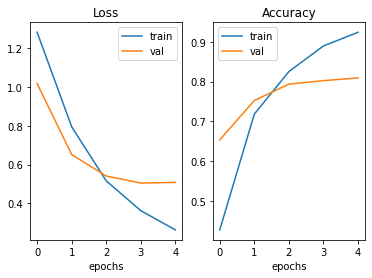

In [17]:
plt.subplot(1,2,1)
plt.plot(stackoverflow_history1.history['loss'])
plt.plot(stackoverflow_history1.history['val_loss'])
plt.xlabel('epochs')
plt.legend(['train','val'])
plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(stackoverflow_history1.history['accuracy'])
plt.plot(stackoverflow_history1.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epochs')
plt.legend(['train','val'])

plt.show()

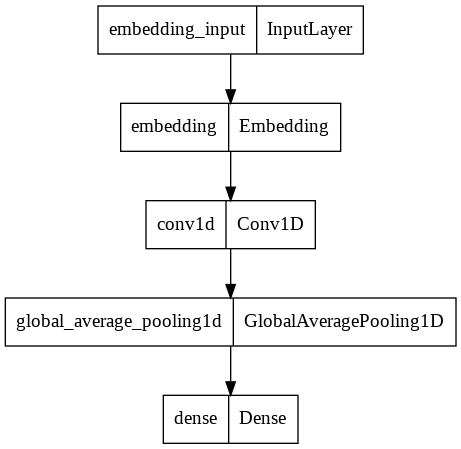

In [24]:
tf.keras.utils.plot_model(stackoverflow_model)

Improve the model 

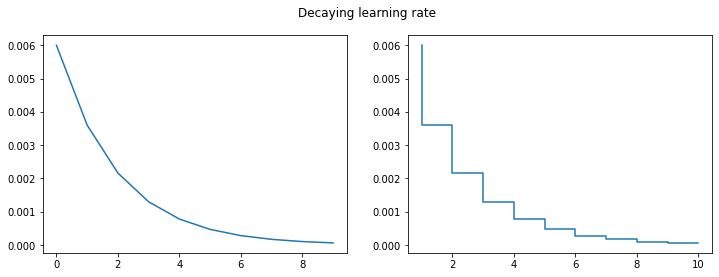

In [18]:
import math
# decaying learing rate
def decay_lr(epoch):
  return 0.01*math.pow(0.6,epoch)

# visualize the decaying rate
decay = []
for i in range(1,11):
  decay.append(decay_lr(i))
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(decay);
plt.subplot(1,2,2)
plt.step(range(1,11),decay);
plt.suptitle('Decaying learning rate');


In [19]:
stackoverflow_model_improved = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim=VOCAB_SIZE+1, output_dim=64, mask_zero=True),
      tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1),
      tf.keras.layers.GlobalMaxPool1D(),
      tf.keras.layers.Dropout(rate=0.4),
      tf.keras.layers.Dense(num_classes)
])

stackoverflow_model_improved.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

lr = tf.keras.callbacks.LearningRateScheduler(decay_lr)
early_stop = tf.keras.callbacks.EarlyStopping()

stackoverflow_history2 = stackoverflow_model_improved.fit(train_ds,
                                                          epochs=10,
                                                          validation_data=val_ds,
                                                          callbacks=[lr,early_stop])

Epoch 1/10
200/200 [==============================] - 6s 25ms/step - loss: 0.9074 - accuracy: 0.6003 - val_loss: 0.5695 - val_accuracy: 0.7788 - lr: 0.0100
Epoch 2/10
200/200 [==============================] - 5s 25ms/step - loss: 0.4894 - accuracy: 0.8059 - val_loss: 0.5453 - val_accuracy: 0.7881 - lr: 0.0060


In [20]:
# evaluate the performance 
loss, accuracy = stackoverflow_model_improved.evaluate(test_ds)
print('Loss',loss)
print('Accuracy',accuracy)

250/250 [==============================] - 4s 16ms/step - loss: 0.5369 - accuracy: 0.7874
Loss 0.5368944406509399
Accuracy 0.7873749732971191


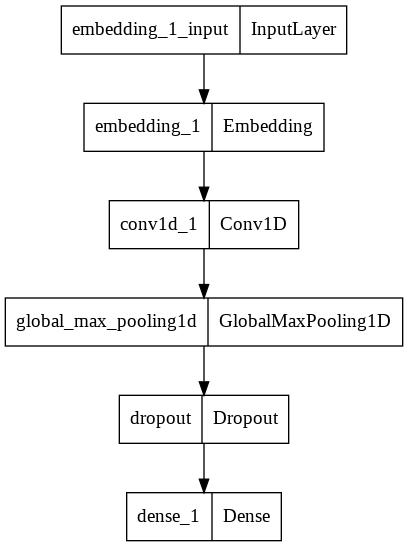

In [25]:
tf.keras.utils.plot_model(stackoverflow_model_improved)

## Example 2: Predict the author of Iliad translations

### Load the data

In [ ]:
DIRECTORY_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/illiad/'
FILE_NAMES = ['cowper.txt', 'derby.txt', 'butler.txt']

for name in FILE_NAMES:
  text_dir = tf.keras.utils.get_file(fname=name, origin=DIRECTORY_URL+name)

parent_dir = pathlib.Path(text_dir).parent
list(parent_dir.iterdir()) 

[PosixPath('/root/.keras/datasets/cowper.txt'),
 PosixPath('/root/.keras/datasets/derby.txt'),
 PosixPath('/root/.keras/datasets/imdb.tar.gz'),
 PosixPath('/root/.keras/datasets/butler.txt'),
 PosixPath('/root/.keras/datasets/imdb')]

In [ ]:
# utility for creating (example,label) pair
def labeler(sample, i):
  return sample, tf.cast(i, tf.int64)

labeled_dataset = []

for i, name in enumerate(FILE_NAMES):
  text = tf.data.TextLineDataset(parent_dir/name)
  pair = text.map(lambda text: labeler(text,i))
  labeled_dataset.append(pair)

In [ ]:
all_labeled_ds = labeled_dataset[0]
for data in labeled_dataset[1:]:
  all_labeled_ds = all_labeled_ds.concatenate(data)

shuffle the data 

In [ ]:
BUFFER_SIZE = 50000

all_labeled_ds = all_labeled_ds.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=False)

### Prepare the dataset for training

In [ ]:
import tensorflow_text as tf_text

# lets use unicode script tokenizer 
tokenizer =tf_text.UnicodeScriptTokenizer()

# Lets create an utility for tokenization
def tokenize(line, label):
  lower = tf_text.case_fold_utf8(line)
  return tokenizer.tokenize(lower)

Apply the tokenization to the dataset.

In [ ]:
tokenized_ds = all_labeled_ds.map(tokenize)

Create a vocabulary using the tokens

In [ ]:
vocab_dict = collections.defaultdict(lambda : 0)

# iterate through the tokenized_ds and create a vocab
for tokens in tokenized_ds:
  for token in tokens.numpy():
    vocab_dict[token]+=1

# order by count decending   
vocab = sorted(vocab_dict.items(), key=lambda x:x[1], reverse=True)
# create a list of tokens 
vocab = [key for key, count in vocab]
# keep only VOCABSIZE tokens
VOCAB_SIZE=10000
vocab = vocab[:VOCAB_SIZE]

In [ ]:
print('The length of vocabulary',len(vocab))

The length of vocabulary 10000


Converting tokens to integers <br>
0 is reserved for padding <br>
1 is reserved for Unkown <br>


In [ ]:
init = tf.lookup.KeyValueTensorInitializer(keys=vocab,
                                           values=range(2,VOCAB_SIZE+2),
                                           key_dtype=tf.string,
                                           value_dtype=tf.int64)

lookup_table = tf.lookup.StaticVocabularyTable(initializer=init, num_oov_buckets=1)

Create an utility to standardize, tokenize and vectorize the dataset using the tokenizer and lookup table:

In [ ]:
def preprocess_text(text,label):
  lowercase = tf_text.case_fold_utf8(text)
  tokenized = tokenizer.tokenize(lowercase)
  return lookup_table.lookup(tokenized), label  

 standardize, tokenize and vectorize the dataset

In [ ]:
all_encoded_ds = all_labeled_ds.map(preprocess_text, num_parallel_calls=tf.data.AUTOTUNE)

Create training and validation split

In [ ]:
VALIDATION_SIZE = 5000
BUFFER_SIZE = 50000

train_ds = all_encoded_ds.skip(VALIDATION_SIZE).shuffle(BUFFER_SIZE)
val_ds = all_encoded_ds.take(VALIDATION_SIZE)

The examples in these datasets are not all the same size—each line of text has a different number of words.**Padding is required here because the examples inside of a batch need to be the same size and shape**

In [ ]:
BATCH_SIZE = 64

train_ds = train_ds.padded_batch(BATCH_SIZE)
val_ds = val_ds.padded_batch(BATCH_SIZE)

In [ ]:
# util to configure the dataset for performance
def configure_ds(ds):
  ds = ds.cache().prefetch(tf.data.AUTOTUNE)
  return ds

In [ ]:
train_ds = configure_ds(train_ds)
val_ds = configure_ds(val_ds)

### Model

In [ ]:
iliad_model = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim=VOCAB_SIZE+2, output_dim=64, mask_zero=True),
      tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1),
      tf.keras.layers.Dropout(rate=0.3),
      tf.keras.layers.GlobalMaxPool1D(),
      tf.keras.layers.Dropout(rate=0.3),
      tf.keras.layers.Dense(3)
])

iliad_model.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

lr = tf.keras.callbacks.LearningRateScheduler(decay_lr)
early_stop = tf.keras.callbacks.EarlyStopping()

iliad_model_history1 = iliad_model.fit(train_ds,
                                       epochs=10,
                                       validation_data=val_ds,
                                       callbacks=[lr,early_stop])

Epoch 1/10
697/697 [==============================] - 35s 22ms/step - loss: 0.5656 - accuracy: 0.7446 - val_loss: 0.4277 - val_accuracy: 0.8172 - lr: 0.0100
Epoch 2/10
697/697 [==============================] - 9s 13ms/step - loss: 0.3744 - accuracy: 0.8458 - val_loss: 0.4271 - val_accuracy: 0.8264 - lr: 0.0060


In [ ]:
# evaluate the model
loss,acc = iliad_model.evaluate(val_ds)
print('Loss',loss)
print('Accuracy',acc)

79/79 [==============================] - 2s 4ms/step - loss: 0.4271 - accuracy: 0.8264
Loss 0.4271393418312073
Accuracy 0.8263999819755554


## Example 3: Sentiment classification IMDb movies

In [ ]:
data_url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

data_dir = tf.keras.utils.get_file(origin=data_url, untar=True, cache_dir='.', cache_subdir='')

84140032/84125825 [==============================] - 5s 0us/step


In [ ]:
parent_dir = pathlib.Path(data_dir).parent

list(parent_dir.iterdir())

[PosixPath('.config'),
 PosixPath('aclImdb_v1.tar.gz'),
 PosixPath('aclImdb'),
 PosixPath('sample_data')]

In [ ]:
imdb_movies = parent_dir/'aclImdb'
list(imdb_movies.iterdir())

[PosixPath('aclImdb/train'),
 PosixPath('aclImdb/test'),
 PosixPath('aclImdb/README'),
 PosixPath('aclImdb/imdbEr.txt'),
 PosixPath('aclImdb/imdb.vocab')]

In [ ]:
train_dir = imdb_movies/'train'
test_dir = imdb_movies/'test'

In [ ]:
[item for item in train_dir.iterdir() if item.is_dir()]

[PosixPath('aclImdb/train/neg'),
 PosixPath('aclImdb/train/pos'),
 PosixPath('aclImdb/train/unsup')]

In [ ]:
[item for item in test_dir.iterdir() if item.is_dir()]

[PosixPath('aclImdb/test/neg'), PosixPath('aclImdb/test/pos')]

The train directory has an additional folder which should be removed before creating training dataset using `tf.keras.utils.text_dataset_from_directory`

In [ ]:
import shutil

dir_to_remove = train_dir/'unsup'
shutil.rmtree(dir_to_remove)

In [ ]:
[item for item in train_dir.iterdir() if item.is_dir()]

[PosixPath('aclImdb/train/neg'), PosixPath('aclImdb/train/pos')]

### Prepare the dataset for training

In [ ]:
BATCH_SIZE = 1024
SEED = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(directory=train_dir,
                                                          batch_size=BATCH_SIZE,
                                                          seed=SEED,
                                                          validation_split=0.2,
                                                          subset='training')
raw_val_ds = tf.keras.utils.text_dataset_from_directory(directory=train_dir,
                                                          batch_size=BATCH_SIZE,
                                                          seed=SEED,
                                                          validation_split=0.2,
                                                          subset='validation')
raw_test_ds = tf.keras.utils.text_dataset_from_directory(directory=test_dir,
                                                          batch_size=BATCH_SIZE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [ ]:
classes = [name for name in raw_train_ds.class_names]
num_classes = len(classes)
print(classes)

['neg', 'pos']


standardize, tokenize, and vectorize the data

In [ ]:
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100

In [ ]:
import re
import string

# create util for standardization
def custom_standardizer(data):
  lower = tf.strings.lower(data)
  strip_html = tf.strings.regex_replace(lower,"<[^>]+>",' ')
  return tf.strings.regex_replace(strip_html, '[{0}]'.format(re.escape(string.punctuation)), '')

In [ ]:
imdb_vectorizer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE,
                                                    output_sequence_length=MAX_SEQUENCE_LENGTH,
                                                    standardize=custom_standardizer)

Create a text only dataset to adapt the vectorizer

In [ ]:
train_text = raw_train_ds.map(lambda text,label:text)
imdb_vectorizer.adapt(train_text)
print('Length of vocabulary is',imdb_vectorizer.vocabulary_size())

Length of vocabulary is 10000


In [ ]:
# util for vectorization
def vectorize(text,label):
  text = tf.expand_dims(text,-1)
  return imdb_vectorizer(text), label

In [ ]:
train_ds = raw_train_ds.map(vectorize, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = raw_val_ds.map(vectorize, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = raw_test_ds.map(vectorize, num_parallel_calls=tf.data.AUTOTUNE)

Configure the dataset for performance

In [ ]:
def configure_ds(ds):
  ds = ds.cache().prefetch(tf.data.AUTOTUNE)
  return ds

In [ ]:
train_ds = configure_ds(train_ds)
val_ds = configure_ds(val_ds)
test_ds = configure_ds(test_ds)

### Model

In [ ]:
imdb_model = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim=VOCAB_SIZE+1, output_dim=64, mask_zero=True),
      tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1),
      tf.keras.layers.Dropout(rate=0.3),
      tf.keras.layers.GlobalMaxPool1D(),
      tf.keras.layers.Dropout(rate=0.3),
      tf.keras.layers.Dense(3)
])

imdb_model.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

lr = tf.keras.callbacks.LearningRateScheduler(decay_lr)
early_stop = tf.keras.callbacks.EarlyStopping()

imdb_model_history1 = imdb_model.fit(train_ds,
                                       epochs=10,
                                       validation_data=val_ds,
                                       callbacks=[lr,early_stop])

Epoch 1/10
20/20 [==============================] - 15s 539ms/step - loss: 0.6948 - accuracy: 0.6019 - val_loss: 0.4949 - val_accuracy: 0.7708 - lr: 0.0100
Epoch 2/10
20/20 [==============================] - 4s 200ms/step - loss: 0.4481 - accuracy: 0.7962 - val_loss: 0.4366 - val_accuracy: 0.8038 - lr: 0.0060


In [ ]:
loss,acc = imdb_model.evaluate(test_ds)
print('Loss',loss)
print('Accuracy',acc)

25/25 [==============================] - 11s 319ms/step - loss: 0.4482 - accuracy: 0.7944
Loss 0.44819721579551697
Accuracy 0.794439971446991
